In [225]:
import cupy as cp 
import numpy as np
import matplotlib.pyplot as plt
import time as t


n = 30000
nt = 1000
dt = 0.01
T = nt * dt
A = 1

t0 = t.perf_counter()
trajs = cp.random.normal(size=(n, nt+1))
trajs = cp.cumsum(trajs, axis=1)
t1 = t.perf_counter()
trajs = (trajs).get()
#Make the nt+1 value = NaN
min_val = np.min(trajs)
max_val = np.max(trajs)
trajs[:, -1] = np.nan


In [226]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
from datashader.datatypes import RaggedArray
from matplotlib import colors
import colorsys as cs 

In [227]:
# Optional colormaps
try:
    import colorcet as cc
    DENSITY_CMAP = cc.fire
except Exception:
    DENSITY_CMAP = "Blues"


def generate_image(
    data: np.ndarray,
    dt: float,
    n: int,
    nt: int,
    min_val:float,
    max_val:float,
    out_png="all_trajectories_overlay.png",
    plot_width=1400,
    plot_height=800,
    background="black",
    xlabel="Time(seconds)",
    ylabel="Displacement(arbitrary units)"
):
    n, nt = data.shape
    t = np.arange(nt, dtype=np.float32) * dt

    x_range = (0, dt*nt)
    y_range = (float(np.nanmin(data)), float(np.nanmax(data)))

    cvs = ds.Canvas(
        plot_width=plot_width,
        plot_height=plot_height,
        x_range=x_range,
        y_range=y_range,
    )

    df_all = pd.DataFrame({
        "time": np.tile(t, n),
        "val":  data.reshape(-1),
        "id":   np.repeat(np.arange(n), nt),
    })
    
    
    agg_all = cvs.line(df_all, x="time", y="val", agg=ds.count())

    img = tf.shade(agg_all, cmap=DENSITY_CMAP, how="log")
    img = tf.set_background(img, background)
    img = tf.dynspread(img, threshold=0.1, max_px=2)

    export_image(img, out_png.replace(".png", ""), fmt=".png")
    
    fig, ax = plt.subplots(figsize=(10, 5), dpi=150)

   
    ax.imshow(
        img.to_pil(),
        extent=[0, dt*(nt-1), min_val, max_val],
        origin="lower",
        aspect="auto",
    )
    ax.tick_params(colors="white")
    for spine in ax.spines.values():
        spine.set_color("white")
    ax.set_facecolor("black")
    ax.set_xlabel(xlabel, color="white")
    ax.set_ylabel(ylabel, color="white")
    fig.patch.set_facecolor("black")
    plt.title("All Trajectories", color="white")

    plt.tight_layout()
    plt.savefig("all_trajectories_overlay.png")
    

    return img



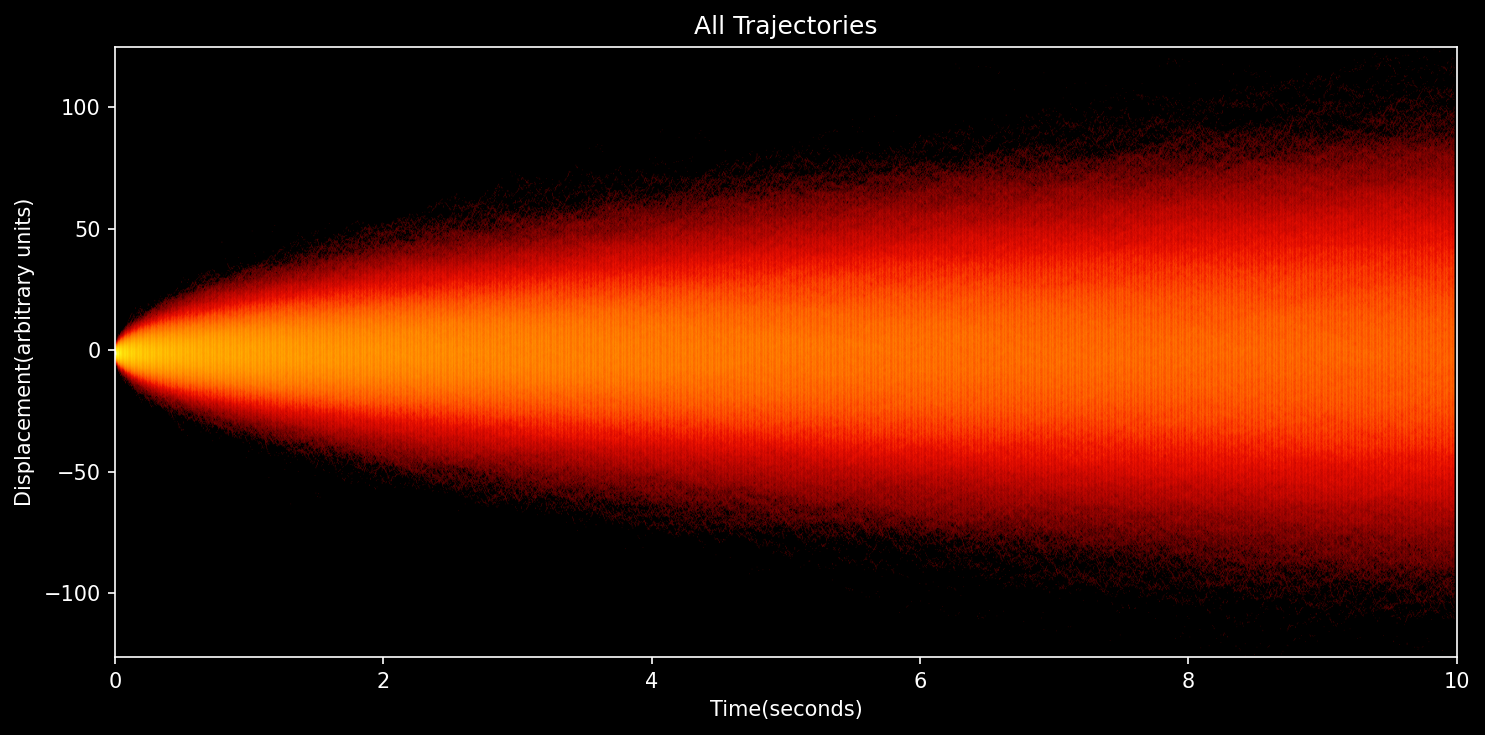

In [228]:

t0 = t.perf_counter()
trajs = cp.random.normal(size=(n, nt+1))
trajs = cp.cumsum(trajs, axis=1)
t1 = t.perf_counter()
trajs = (trajs).get()
#Make the nt+1 value = NaN
min_val = np.min(trajs)
max_val = np.max(trajs)
trajs[:, -1] = np.nan

generate_image(
    trajs,
    dt=dt,
    n=n,
    nt=nt,
    out_png="all_trajectories_overlay.png",
    plot_width=1600,
    plot_height=900,
    min_val=min_val,
    max_val=max_val,
);

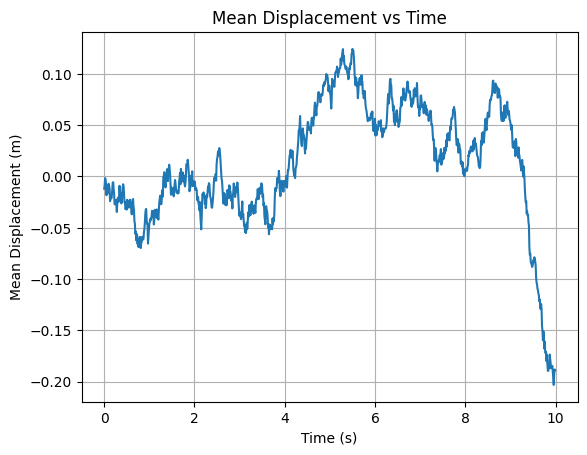

In [229]:
def plt_settings(title:str, xlabel:str, ylabel:str, colour:str='blue'):

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()



mean_displacement_vs_time = cp.mean(trajs, axis=0)
plt.plot(np.arange(nt+1)*dt, mean_displacement_vs_time)
plt_settings("Mean Displacement vs Time", "Time (s)", "Mean Displacement (m)")
# msd_vs_time = cp.square(trajs)

In [230]:
def perform_studies_01(n_min, n_factor, n_n, nt, dt):
    # mean_x_vals = []
    # mean_x_sq_vals = []
    A = 1
    _, ax_mean = plt.subplots(figsize=(10, 5), dpi=150)
    _, ax_mean_sq = plt.subplots(figsize=(10, 5), dpi=150)
    _, ax_mean_log = plt.subplots(figsize=(7, 7), dpi=150)

    time_vals = [(i) * dt for i in range(nt)]
    for i in range(1, n_n):
        n = n_min *(n_factor ** i)
        trajs = cp.random.normal(size=(n, nt))* A*np.sqrt(dt)
        
        trajs = cp.cumsum(trajs, axis=1)
        trajs_mean = cp.mean(trajs, axis=0)
        trajs_sq= cp.square(trajs)
        trajs_sq_mean = cp.mean(trajs_sq, axis=0)
        x_measure_high = 0.9
        x_measure_low = 0.2
        alpha = np.log(trajs_sq_mean[round(nt*x_measure_high)]/trajs_sq_mean[round(nt*x_measure_low)])/np.log(x_measure_high/x_measure_low)
        print(f"Log-Log slope for n={n} and dt={dt}: {alpha}")



        ax_mean.plot(time_vals, trajs_mean.get(), label=f"n={n}, dt={dt}")
        ax_mean_sq.plot(time_vals, trajs_sq_mean.get(), label=f"n={n}, dt={dt}")
        ax_mean_log.loglog(time_vals, trajs_sq_mean.get(), label=f"n={n}, dt={dt}")


    ax_mean.legend()
    ax_mean_sq.legend()
    ax_mean_log.legend()
    
    ax_mean.set_title("Mean Displacement vs Time for different n")
    ax_mean_sq.set_title("Mean Squared Displacement vs Time for different n")
    ax_mean_log.set_title("Mean Log Displacement vs Time for different n")
    
    ax_mean.set_xlabel("Time (s)")
    ax_mean_sq.set_xlabel("Time (s)")
    ax_mean_log.set_xlabel("Time (s)")
    
    ax_mean.set_ylabel("Mean Displacement (length_unit)")
    ax_mean_sq.set_ylabel("Mean Squared Displacement (length_unit^2)")
    ax_mean_log.set_ylabel("Mean Log Displacement (length_unit)")

    # plot_mean_x_vals.show()
    # plot_mean_x_sq_vals.show()
    # plot_mean_x_log_vals.show()


Log-Log slope for n=2048 and dt=0.01: 0.9961059039180664
Log-Log slope for n=4096 and dt=0.01: 1.0008539237289338
Log-Log slope for n=8192 and dt=0.01: 1.016011051636166
Log-Log slope for n=16384 and dt=0.01: 1.0087502692144643
Log-Log slope for n=32768 and dt=0.01: 1.0004192269134955
Log-Log slope for n=65536 and dt=0.01: 0.9964415608091649


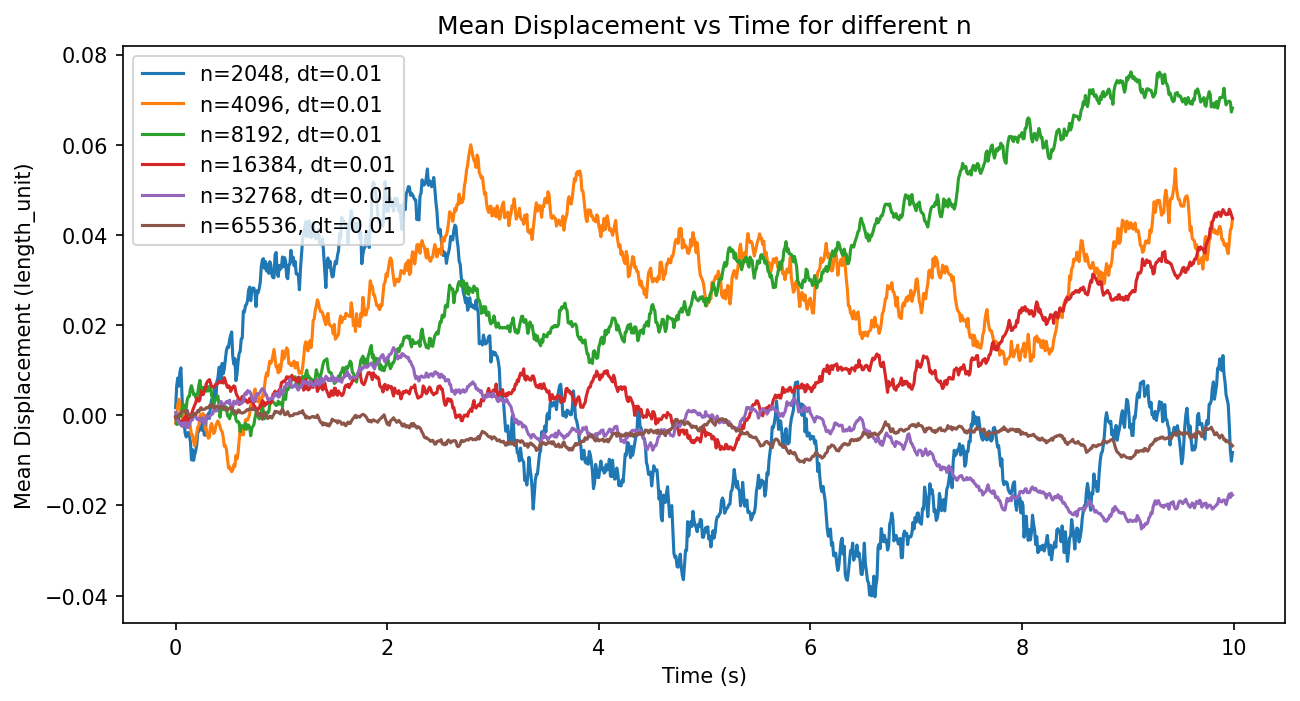

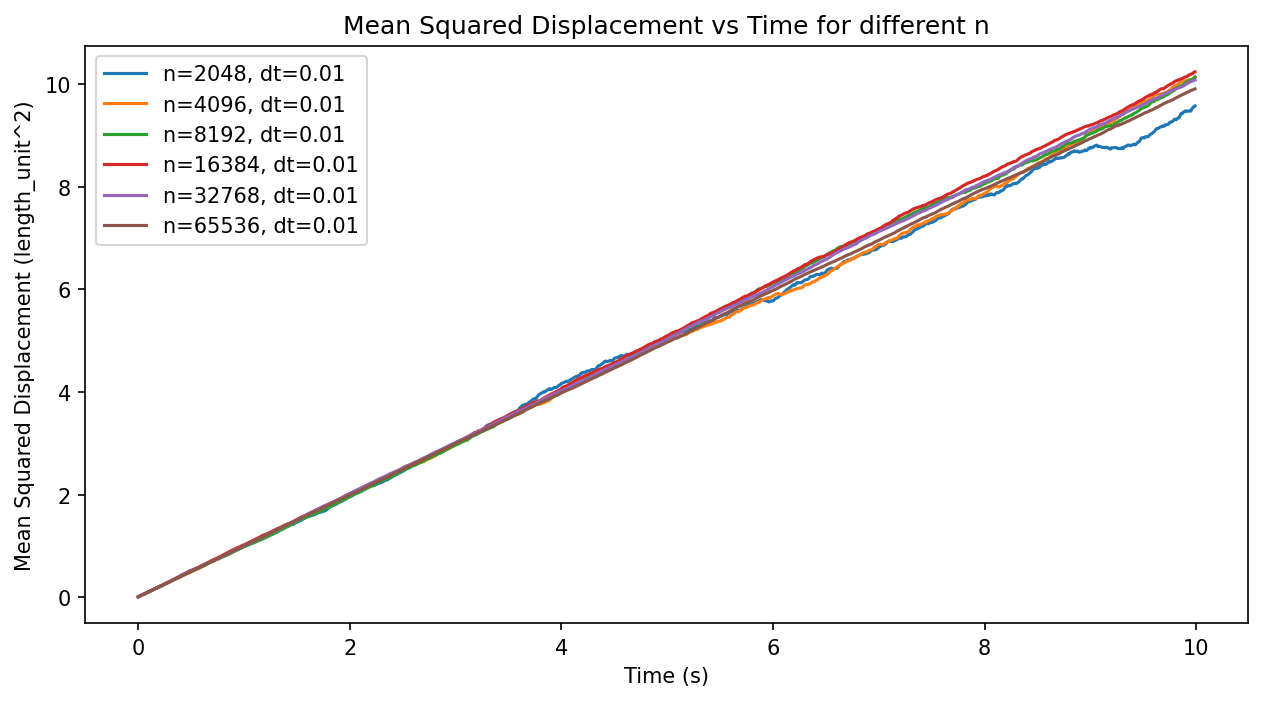

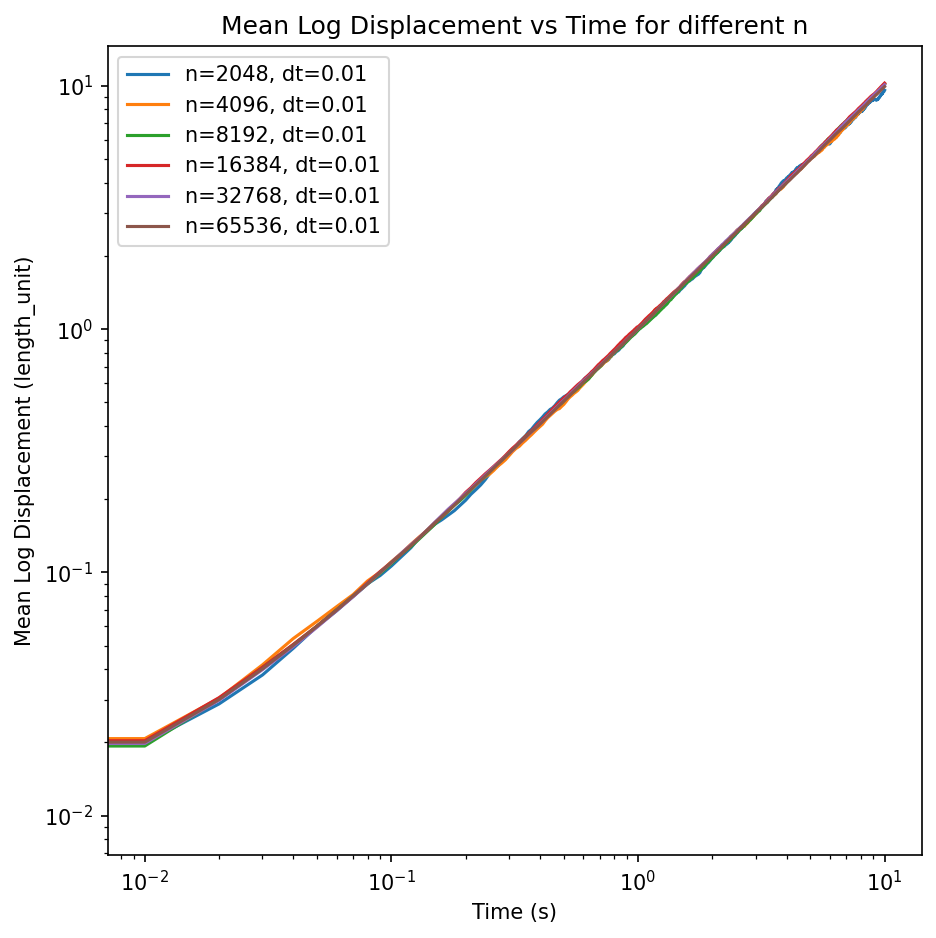

In [231]:
perform_studies_01(1024, 2, 7, nt, dt);

In [232]:
def perform_studies_02(n_min, n_factor, n_n, dt_min, dt_max, n_dt, T):
    A = 1

    for ni in range(n_n):
        fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
        n = n_min * (n_factor ** ni)
        sq_mean_vals = []
        stds = []
        for i in range(n_dt):
            dt = dt_min + i * (dt_max - dt_min) / (n_dt - 1)
            nt = round(T/dt)
            x_vals = np.arange(nt) * dt
            trajs = cp.random.normal(size=(n, nt))
            
            # print(trajs.shape)
            trajs = cp.cumsum(trajs, axis=1) * A * np.sqrt(dt)
            # trajs = (trajs).get()
            min_val = cp.min(trajs)
            max_val = cp.max(trajs)
            trajs_sq = cp.square(trajs)
            trajs_sq_mean = cp.mean(trajs_sq, axis=0).get()
            # sq_mean_vals.append([trajs_sq_mean.get()])
            deviation = trajs_sq_mean - A * A * x_vals
            std = cp.std(cp.array(deviation), axis=0).get()
            # std = cp.std(cp.array()).get()
            ax.plot(x_vals, trajs_sq_mean, label=f"dt={dt}")
            stds.append(std)
            print(f"Standard deviation for dt={dt}, n={n}: {std}")
        print(f"Average std from exact solution for n={n}: {cp.mean(cp.array(stds)).get()}")
        print(f"")
        ax.plot(x_vals, A**2 * x_vals, 'k--', label="MSD ~ t")
        # print(np.array(sq_mean_vals).shape)
        # sq_mean_vals = cp.array()
        # sq_mean_vals_std = cp.std(sq_mean_vals, axis=0)
        # average_std_dev = cp.mean(sq_mean_vals_std)
        # print(f"Average standard deviation for n={n}: {average_std_dev}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("MSD (length_unit^2)")
        ax.set_title(f"MSD vs Time, n={n}")
        ax.legend()
        # plt.show()


Standard deviation for dt=0.001, n=1024: 0.07401087329825683
Standard deviation for dt=0.002, n=1024: 0.059919204041902485
Standard deviation for dt=0.003, n=1024: 0.08484374557179115
Standard deviation for dt=0.004, n=1024: 0.10087158218214314
Standard deviation for dt=0.005, n=1024: 0.05752062837534457
Average std from exact solution for n=1024: 0.07543320669388763

Standard deviation for dt=0.001, n=2048: 0.05298852300884124
Standard deviation for dt=0.002, n=2048: 0.0515561980850514
Standard deviation for dt=0.003, n=2048: 0.06580956125856731
Standard deviation for dt=0.004, n=2048: 0.06305991422116053
Standard deviation for dt=0.005, n=2048: 0.04391968874652106
Average std from exact solution for n=2048: 0.055466777064028305

Standard deviation for dt=0.001, n=4096: 0.026791900359337813
Standard deviation for dt=0.002, n=4096: 0.03340280994151236
Standard deviation for dt=0.003, n=4096: 0.020897182410176404
Standard deviation for dt=0.004, n=4096: 0.07138182918760407
Standard devi

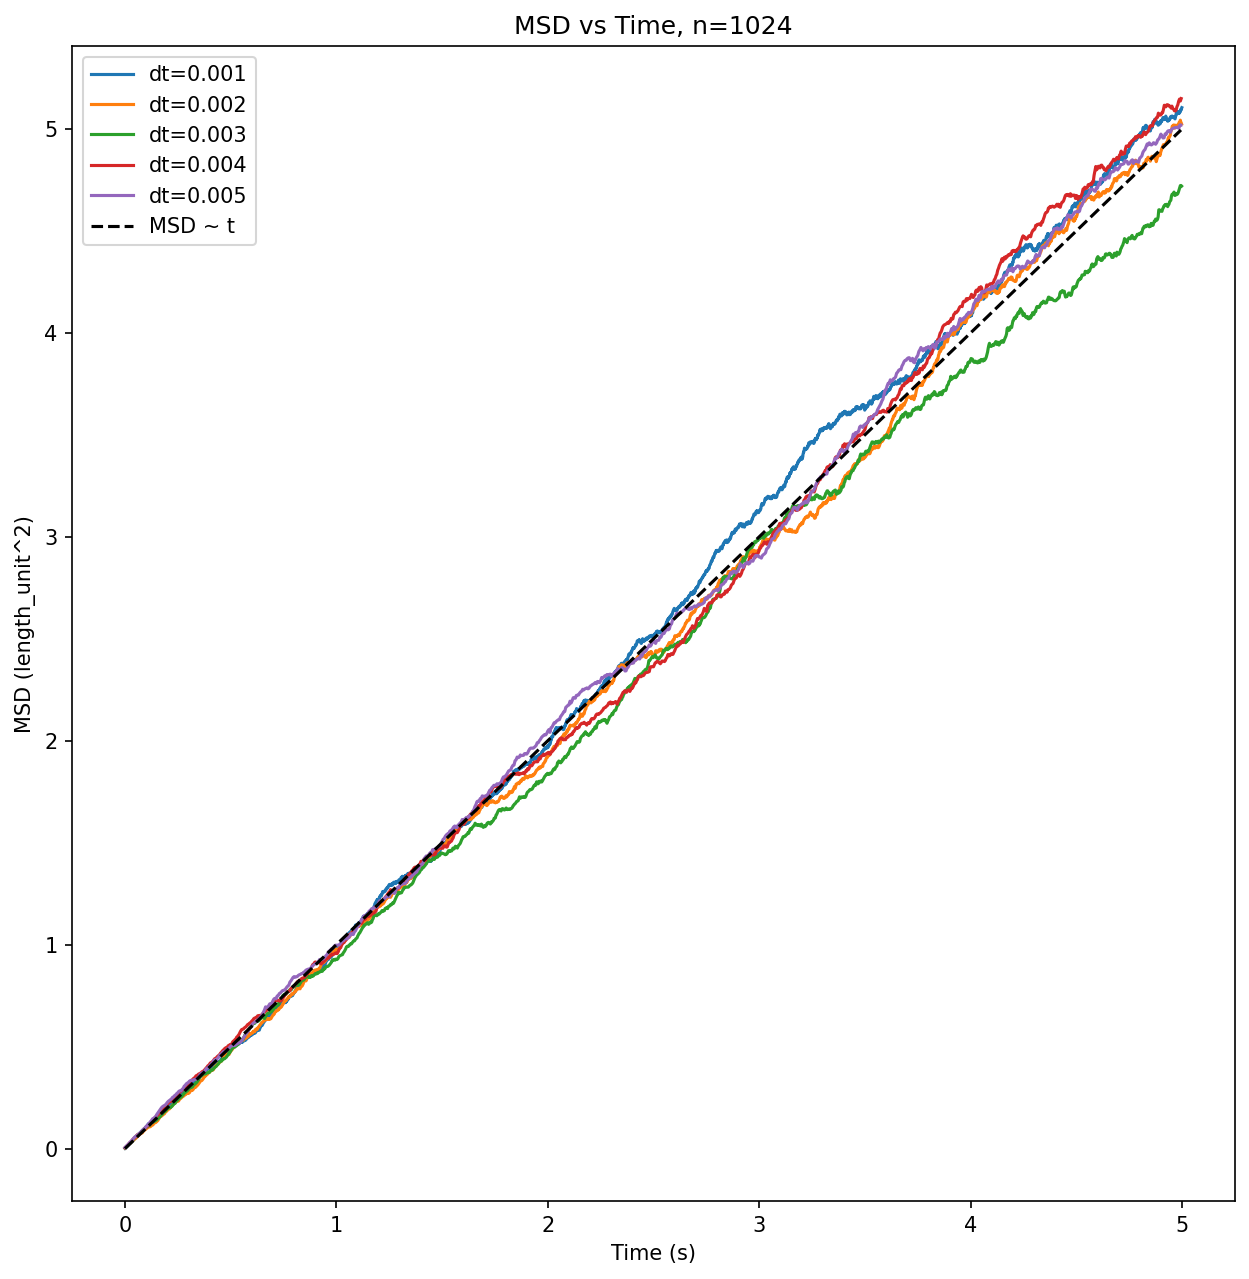

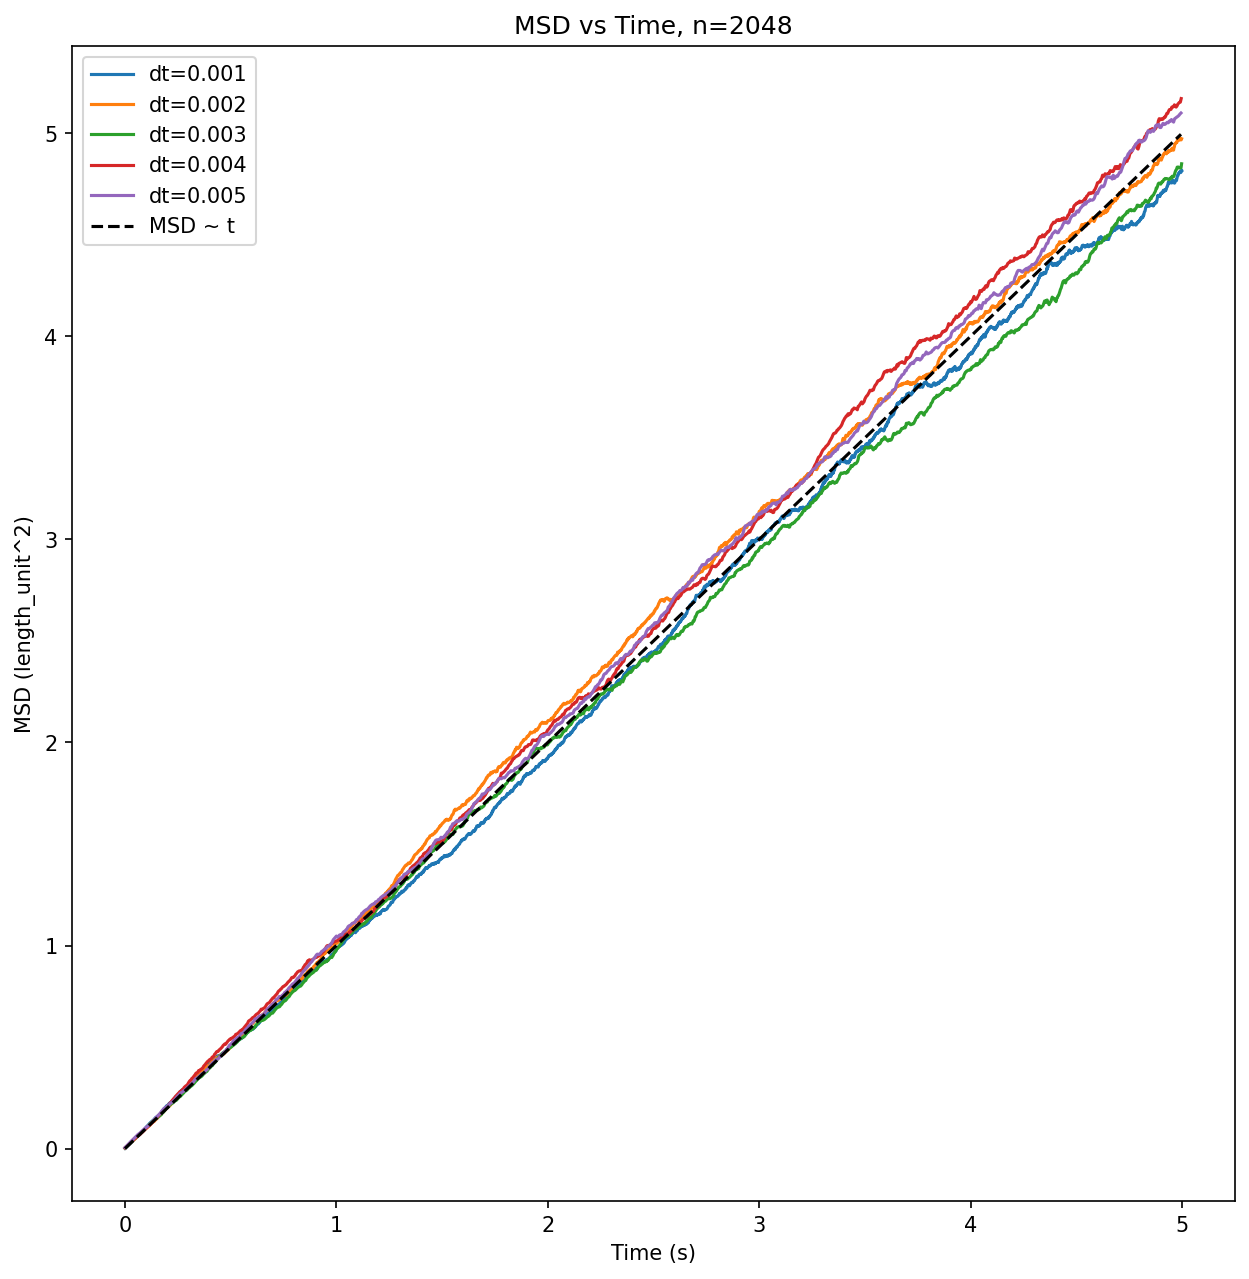

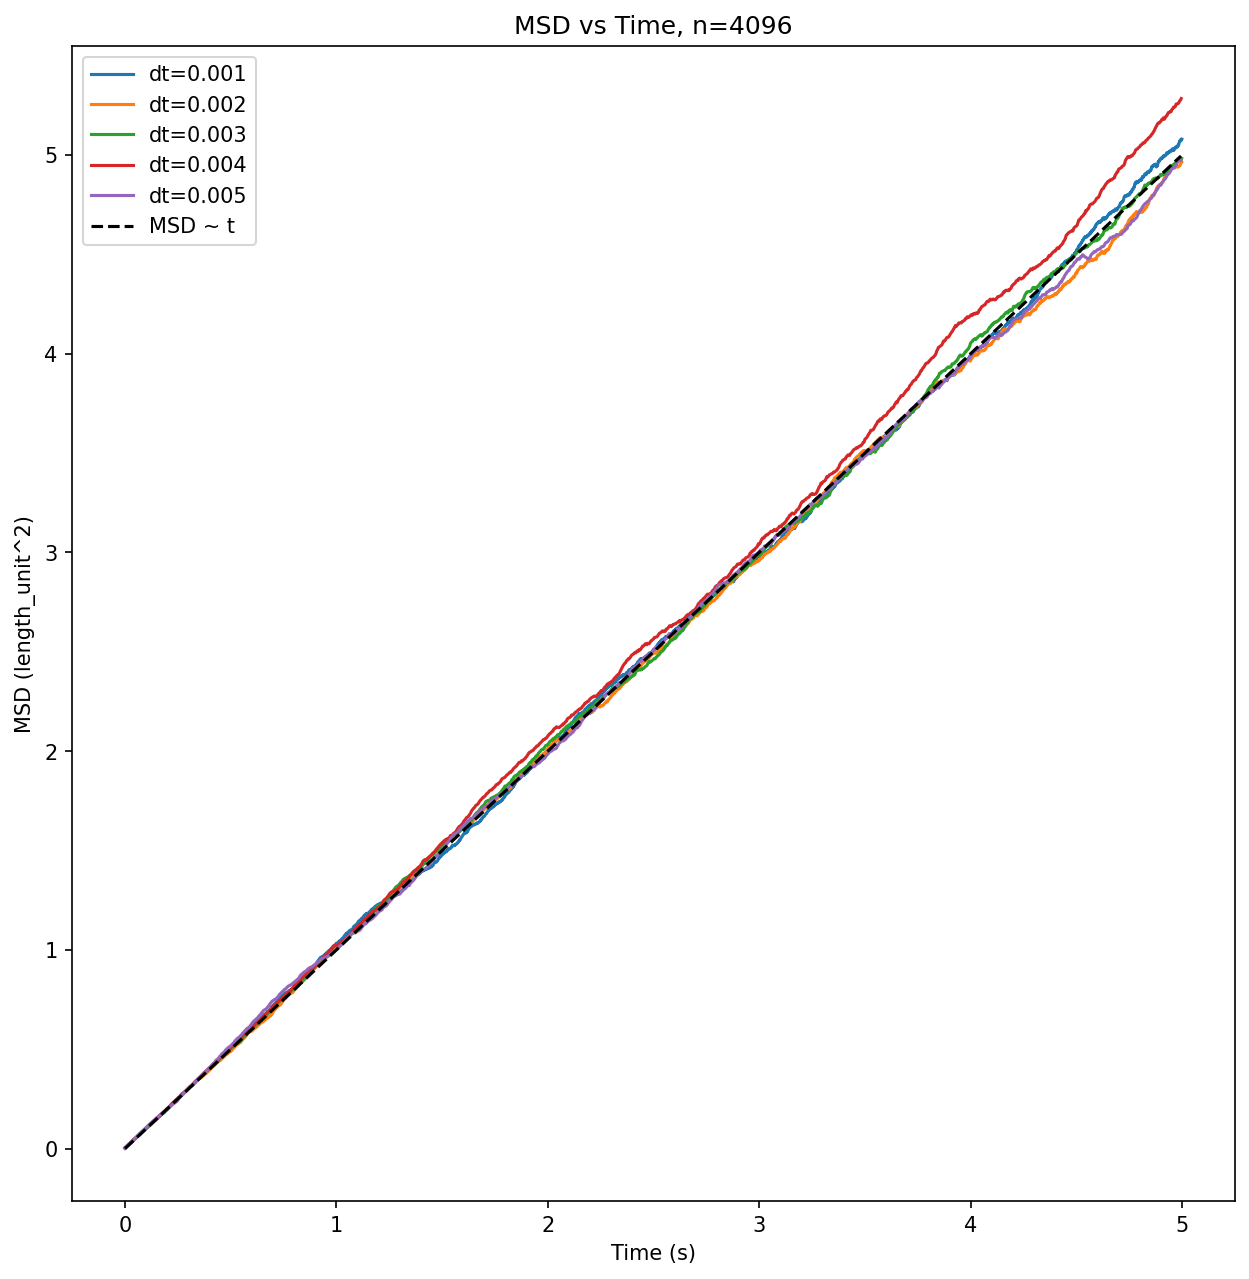

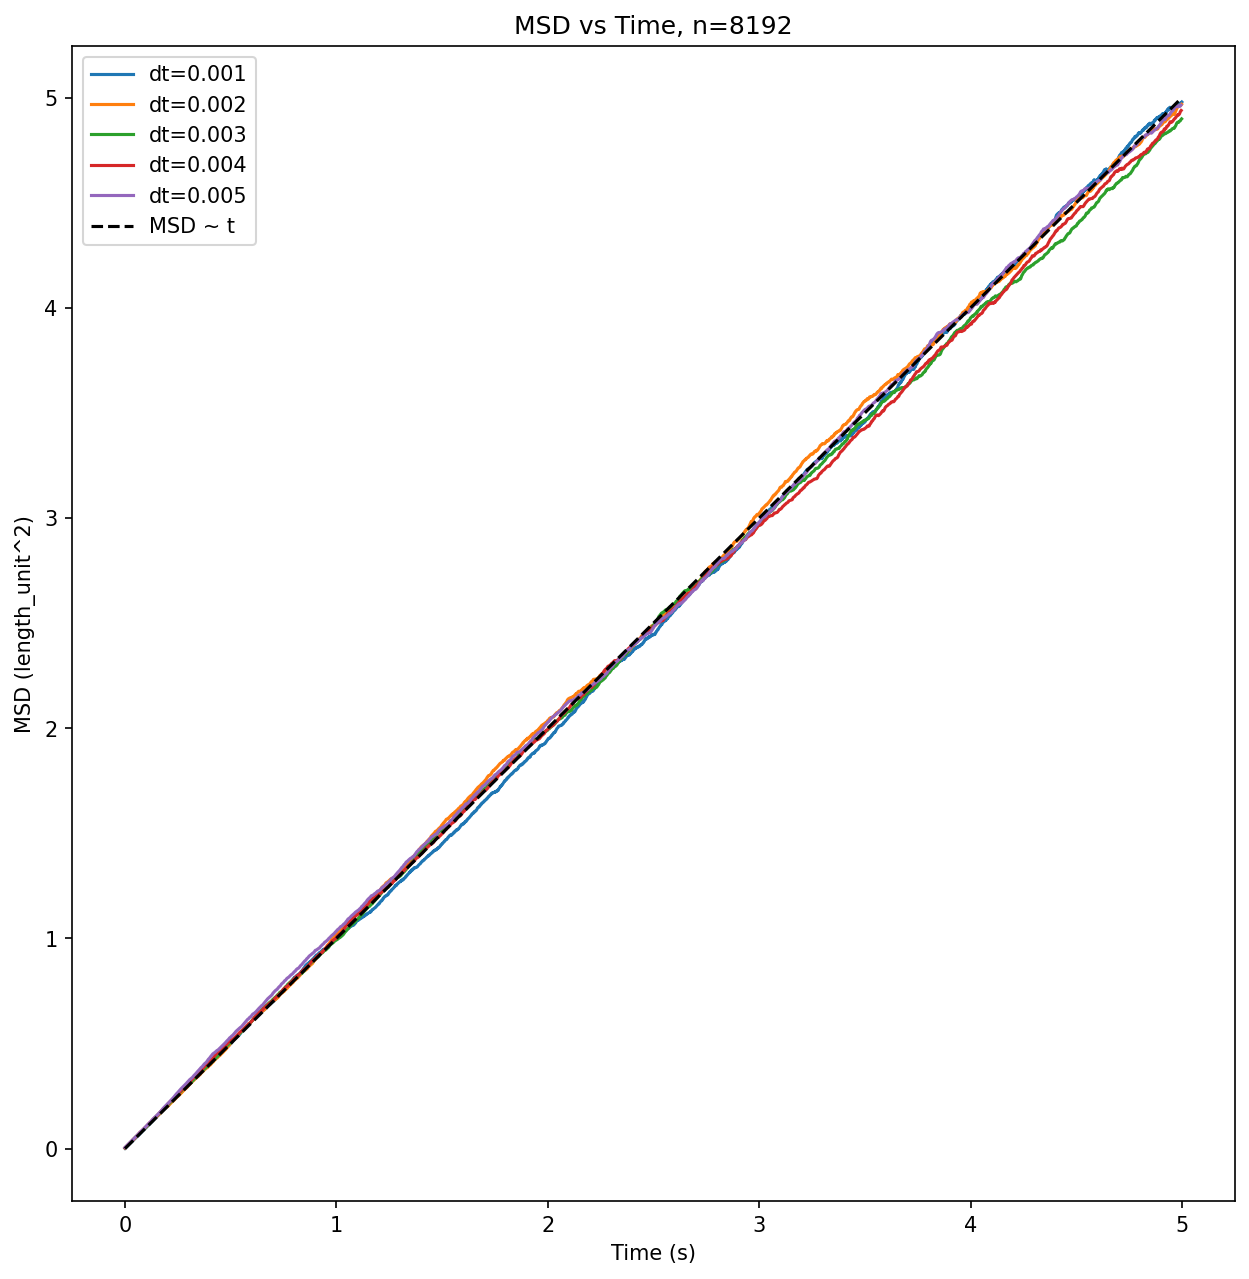

In [233]:
perform_studies_02(1024, 2, 4, 0.001, 0.005, 5, 5);

In [234]:
def perform_studies_03(n_min, n_factor, n_n, dt_min, dt_max, n_dt, T):
    A = 1
    num_distributions = 3
    hsl1 = 0.5*(1/num_distributions)+0.1
    hsl2 = hsl1 + (1/num_distributions)
    dhsl = (1/num_distributions)*0.7
    hsl3 = hsl2 + (1/num_distributions)
    

    for i_t in range(n_dt):
        dt = dt_min + i_t * (dt_max - dt_min) / (n_dt - 1)
        nt = round(T/dt)
        fig, ax= plt.subplots(figsize=(10, 10), dpi=150)
        
    
        sq_mean_vals = []
        stds = []
        x_vals = np.arange(nt) * dt
        
        for ni in range(n_n):
            n = n_min * (n_factor ** ni)
            trajs = cp.random.normal(size=(n, nt)) * A*cp.sqrt(dt)
            trajs = cp.cumsum(trajs, axis=1) * A * np.sqrt(dt)
            trajs_sq = cp.square(trajs)
            trajs_sq_mean = cp.mean(trajs_sq, axis=0).get()
            ax.plot(x_vals, trajs_sq_mean, color=cs.hsv_to_rgb(hsl1 + dhsl * ni/n_n, 1.0, 1.0), label=f"n={n}, Gaussian")
        
            trajs = cp.random.uniform(low=-A/2, high=A/2, size=(n, nt)) * cp.sqrt(dt/(1/12))
            trajs = cp.cumsum(trajs, axis=1) * A * np.sqrt(dt)
            trajs_sq = cp.square(trajs)
            trajs_sq_mean = cp.mean(trajs_sq, axis=0).get()
            ax.plot(x_vals, trajs_sq_mean, color=cs.hsv_to_rgb(hsl2 + dhsl * ni/n_n, 1.0   , 1.0), label=f"n={n}, Uniform")
            
            trajs = cp.random.exponential(scale=A*np.sqrt(dt), size=(n, nt)) - A*cp.sqrt(dt)
            trajs = cp.cumsum(trajs, axis=1) * A * np.sqrt(dt)
            trajs_sq = cp.square(trajs)
            trajs_sq_mean = cp.mean(trajs_sq, axis=0).get()
            ax.plot(x_vals, trajs_sq_mean, color=cs.hsv_to_rgb(hsl3 + dhsl * ni/n_n, 1.0   , 1.0), label=f"n={n}, Exponential")
            
            ax.set_xlabel("Time (s)")
            ax.set_ylabel("MSD (length_unit^2)")
            ax.set_title(f"MSD vs Time, Gaussian vs Uniform vs Exponential(Grouped by hue), dt={dt}")
            ax.legend()

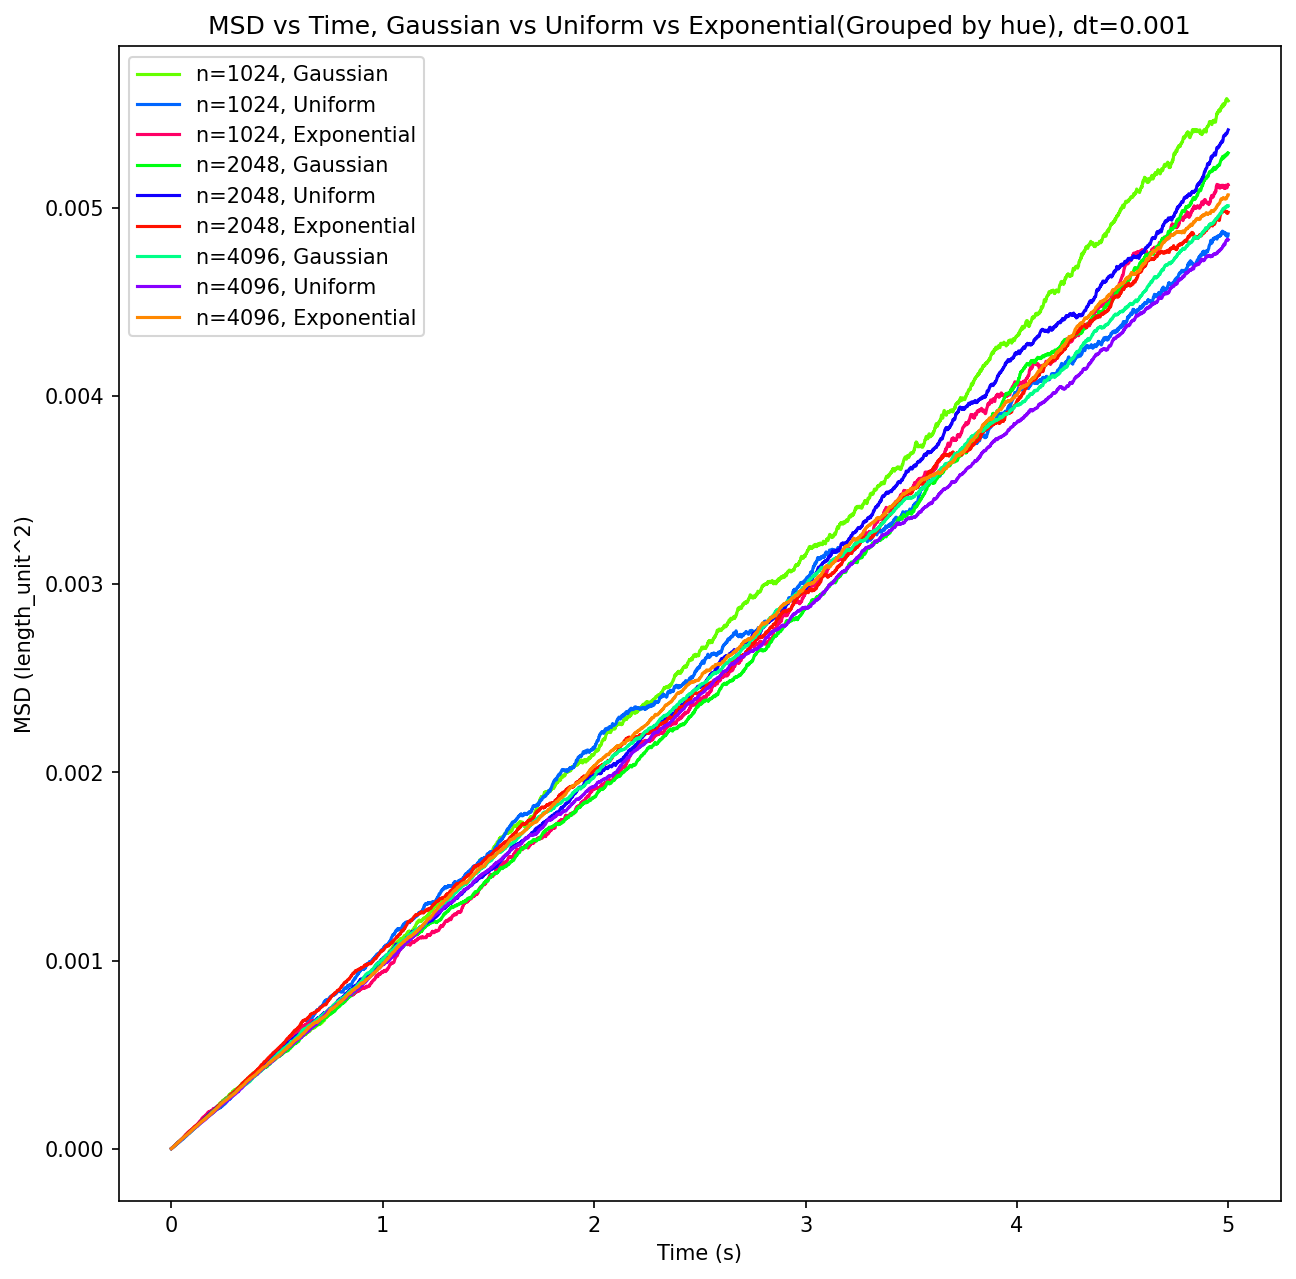

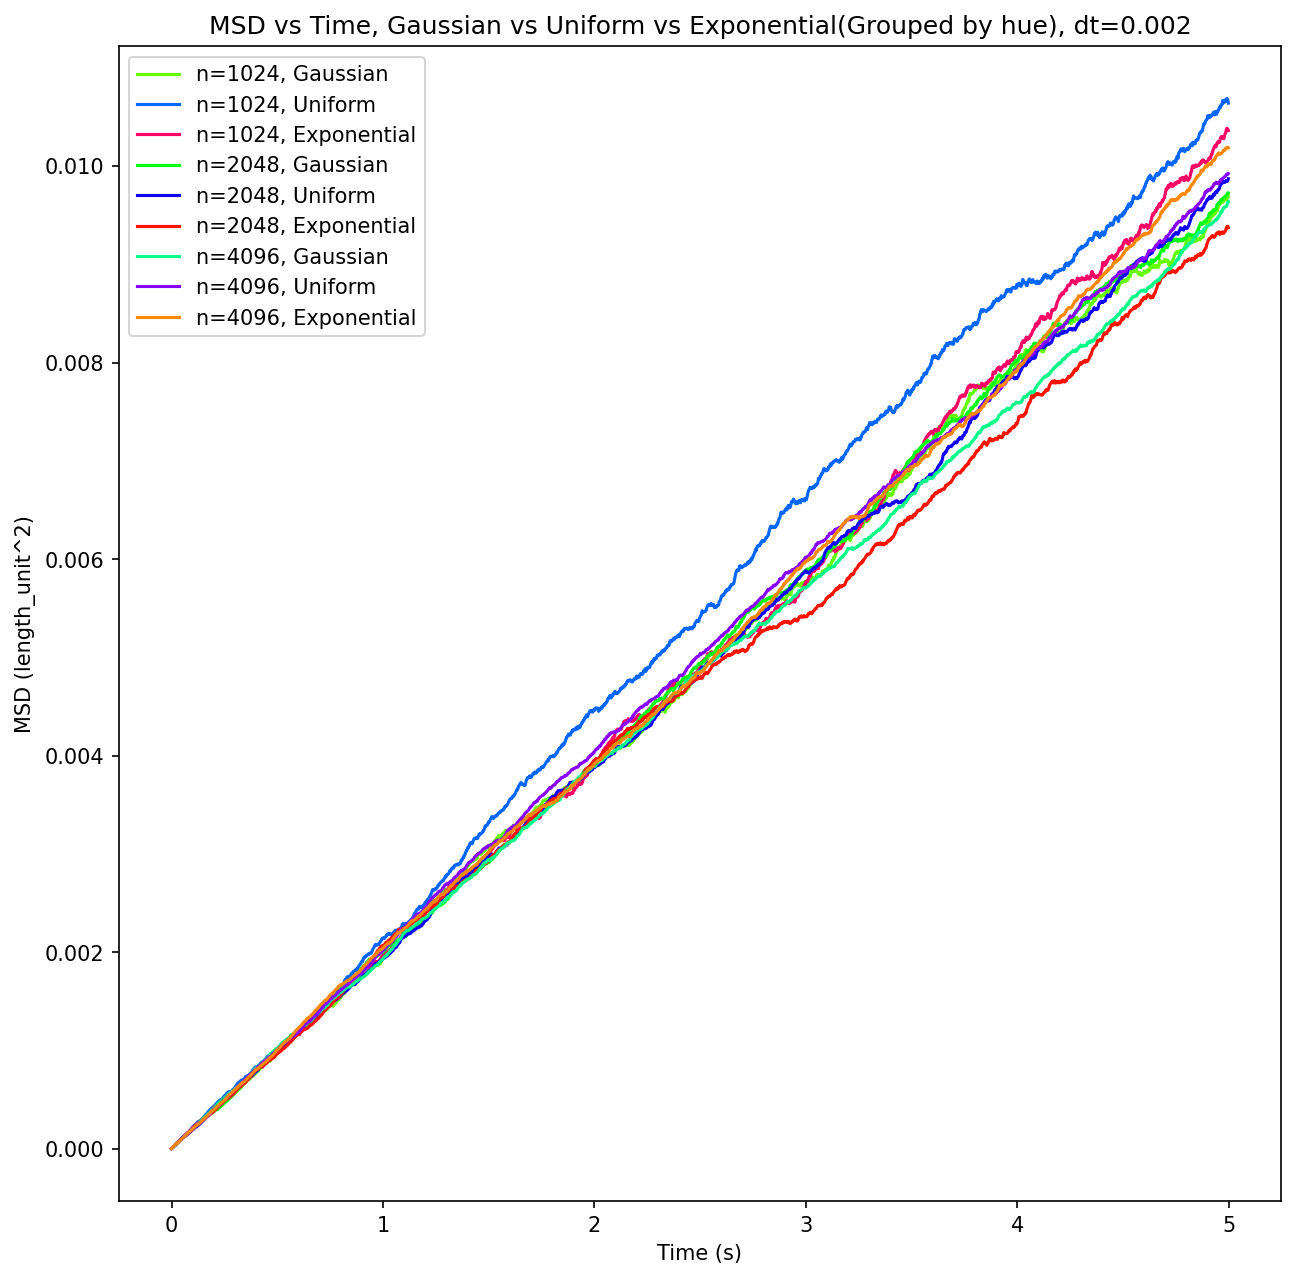

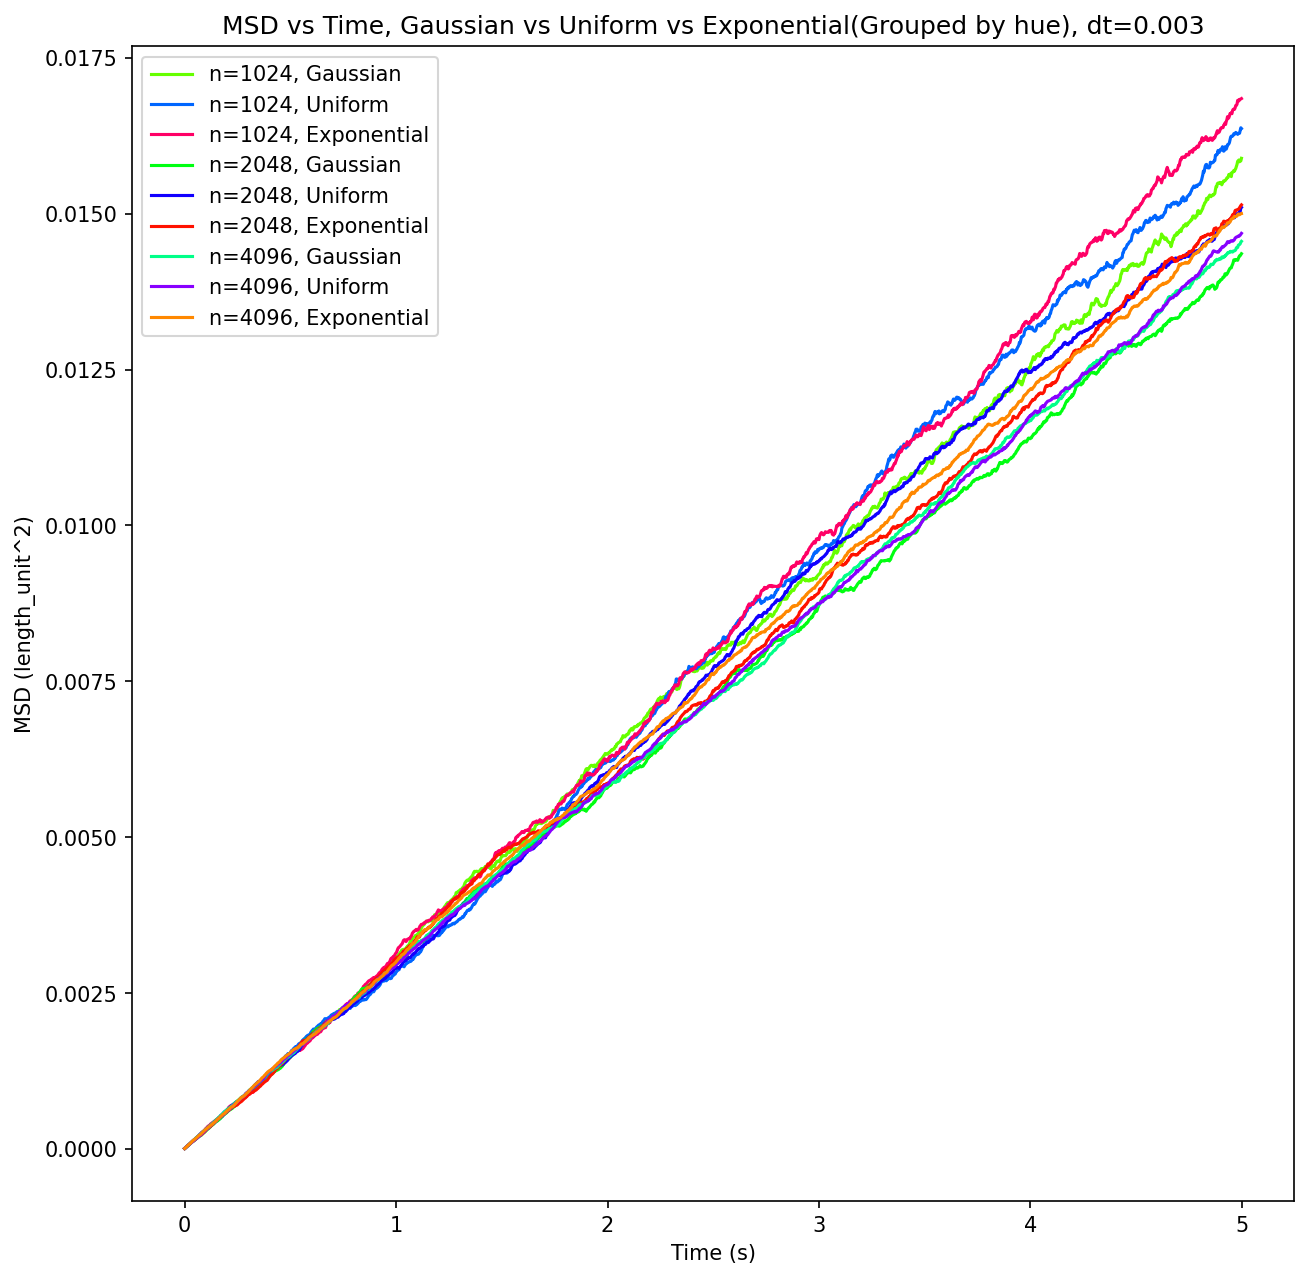

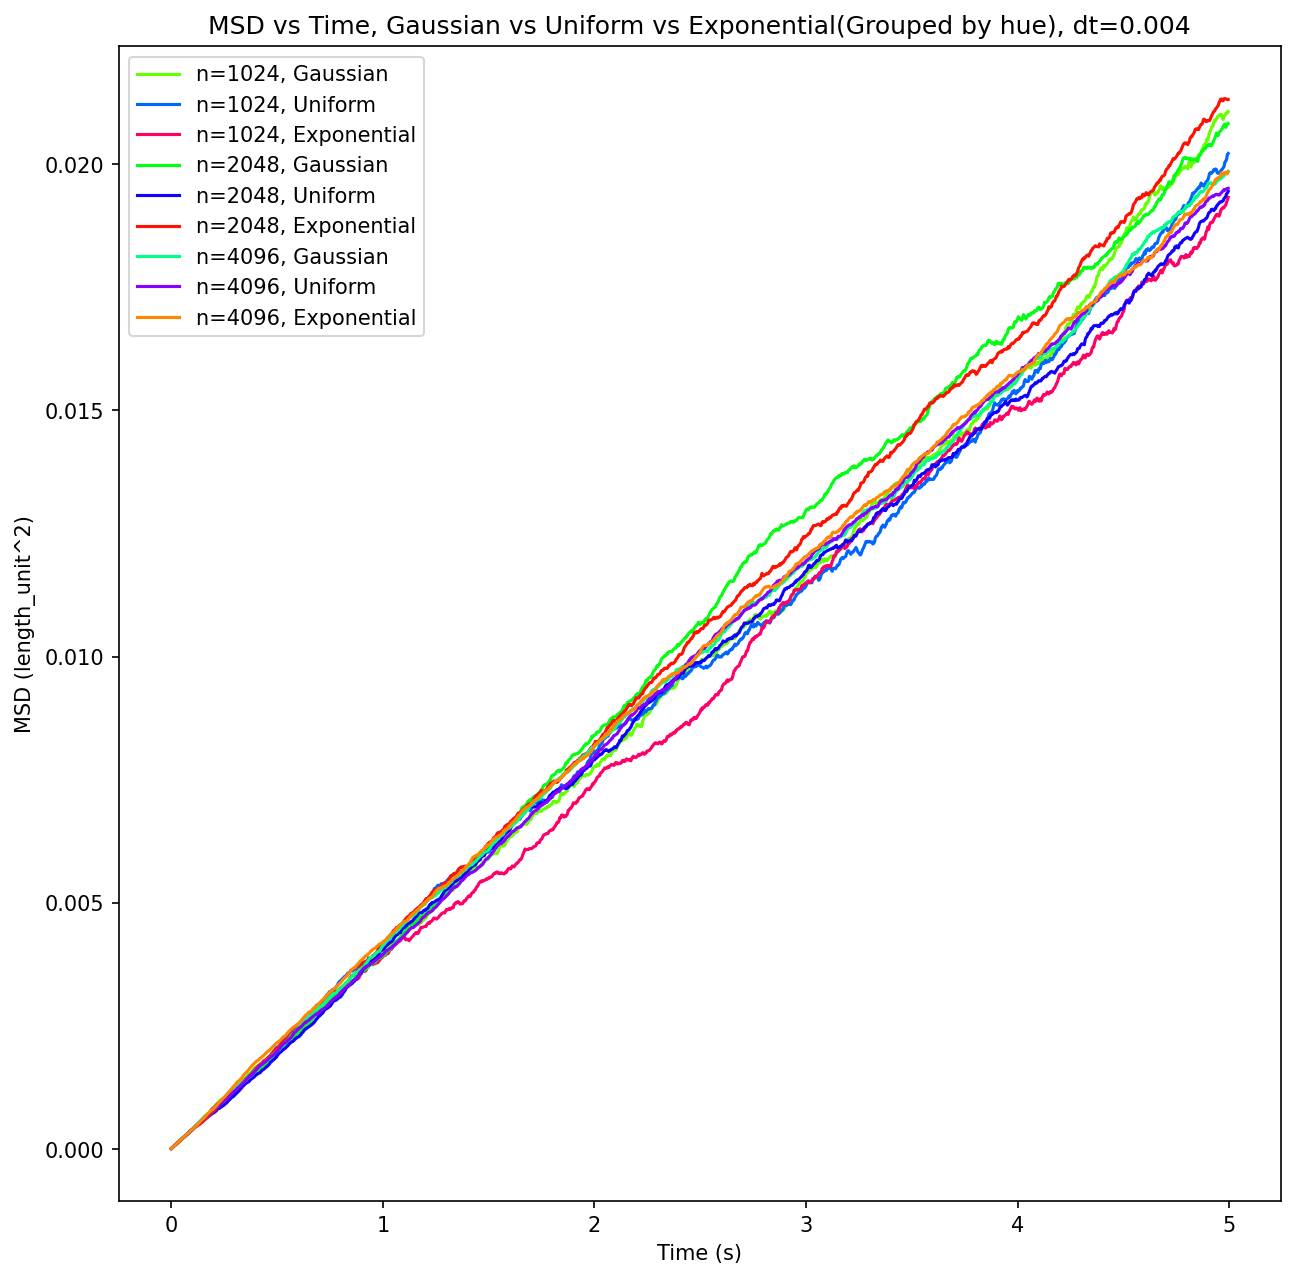

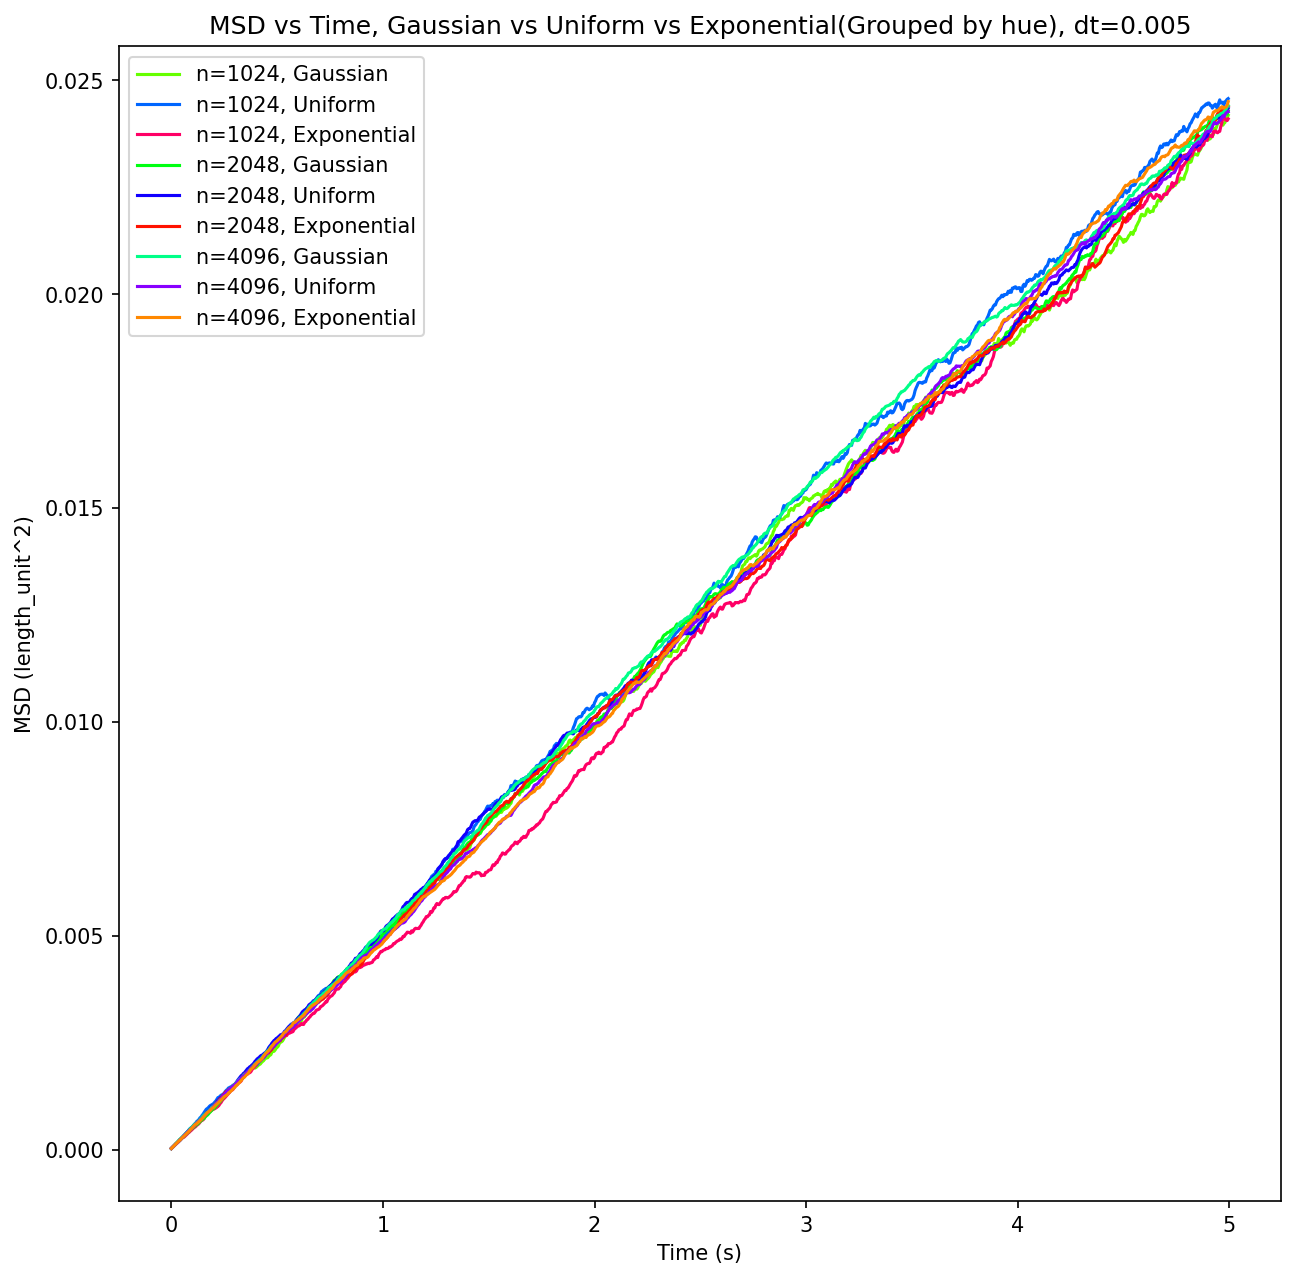

In [235]:
perform_studies_03(1024, 2, 3, 0.001, 0.005, 5, 5);